In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
pd.set_option('display.max_rows', 10)

%load_ext autoreload
%autoreload 2

# Potential impact of post-exposure prophalaxis for COVID-19 with monoclonal antibodies

Updated from March 2021 analysis to include more recent confirmed cases, and also vaccination coverage.

Also updated to use completed, and now peer-reviewed, results from RCT

And in this version, use the KFF survey results that 77% of unvaccinated adults say everyone in their household is unvaccinated. https://www.kff.org/coronavirus-covid-19/poll-finding/kff-covid-19-vaccine-monitor-june-2021/

In [2]:
# range of values to consider in alternative scenarios
coverage_levels = [0, 1/4, 1/2, 3/4, 1]
age_lower_bounds = [0, 20, 40, 50, 60, 70, 80]

In [3]:
n_draws = 100 # number of bootstrap resamples for quantifying uncertainty
np.random.seed(12345)  # set random seed for reproducibility

In [4]:
attack_rate_without_mAbs = np.random.binomial(752, 59/752, size=n_draws) / 752
attack_rate_with_mAbs = np.random.binomial(753, 11/753, size=n_draws) / 753

mAbs_unit_cost = np.random.normal(1_250, 125, size=n_draws)  # 1_250 is what it says online;
COVID_hospitalization_unit_cost = np.random.normal(73_300, 7_330, size=n_draws)

In [251]:
# Administrated data on how many vaccines have been given in the US
url = "https://data.cdc.gov/api/views/rh2h-3yt2/rows.csv?accessType=DOWNLOAD"
vax_dt = pd.read_csv(url)
vax_dt

,Date,MMWR_week,Location,Administered_Daily,Administered_Cumulative,Administered_7_Day_Rolling_Average,Admin_Dose_1_Daily,Admin_Dose_1_Cumulative,Admin_Dose_1_Day_Rolling_Average,date_type,Administered_daily_change_report,Administered_daily_change_report_7dayroll,Series_Complete_Daily,Series_Complete_Cumulative,Series_Complete_Day_Rolling_Average
0,08/04/2021,31,NJ,0,10443839,11616,0,5726878,7482,Admin,0,11617,0,5079450,4595
1,08/04/2021,31,TN,12960,5805067,13415,8901,3159076,9221,Report,12960,13415,3658,2684149,3814
2,08/04/2021,31,US,0,348102478,355890,0,192614017,247858,Admin,0,355891,0,165334987,121455
3,08/04/2021,31,AL,0,3646234,8987,0,2104017,7352,Admin,0,8987,0,1651691,1873
4,08/04/2021,31,LA,21870,3698745,15231,17756,2058619,12520,Report,21870,15231,4588,1727145,3098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28665,12/13/2020,51,GA,1652,1652,1652,1382,1382,1382,Admin,1652,1652,272,272,272
28666,12/13/2020,51,SC,255,255,255,226,226,226,Admin,255,255,29,29,29
28667,12/13/2020,51,MD,305,305,305,266,266,266,Admin,305,305,45,45,45
28668,12/13/2020,51,DC,0,0,0,0,0,0,Report,0,0,0,0,0


In [254]:
total_vax = vax_dt[(vax_dt["Date"] == "05/31/2021") & (vax_dt["date_type"] == "Report") & (vax_dt["Location"] == "US")]
us_pop = 332_378_911 #census population on 5/31/2021 (https://www.census.gov/popclock/)

p_vax   = (total_vax.Admin_Dose_1_Cumulative/us_pop).round(2)
p_unvax = 1-p_vax
p_vax, p_unvax

(8031    0.51
 Name: Admin_Dose_1_Cumulative, dtype: float64,
 8031    0.49
 Name: Admin_Dose_1_Cumulative, dtype: float64)

In [255]:
efficacy = 0.95

## equ1: p_cc = (p_cc_vax*p_vax) + (p_cc_unvax*p_unvax)
## equ2: p_unvax_cc = (p_cc_unvax * p_unvax)/p_cc
## equ3: p_cc_vax = efficacy * p_cc_unvax

## substitute equ3 into equ1: p_cc = ((efficacy * p_cc_unvax) * p_vax) + (p_cc_unvax*p_unvax)
## p_cc = p_cc_unvax((efficacy * p_vax) + p_unvax)

## substitute equ1 into equ2: p_unvax_cc = (p_cc_unvax * p_unvax) / p_cc_unvax((efficacy * p_vax) + p_unvax)
p_unvax_cc =  p_unvax / ((efficacy * (p_vax)) + p_unvax)
p_unvax_cc

0.7106598984771574

In [4]:
pr_unvaccinated_cond_on_test_positive = np.random.binomial(10_000, unvac_covPos, size=n_draws)/10_000 

# https://files.kff.org/attachment/Topline-KFF-COVID-19-Vaccine-Monitor-June-2021.pdf
# n = 458, p_all_hh_members unvaccinated = 0.69
pr_case_in_unvaccinated_household = pr_unvaccinated_cond_on_test_positive * np.random.binomial(458, 0.69, size=n_draws) / 458

In [5]:
%%time

df_cdc = pd.read_csv('data/cdc_covid_linelist_may_2021.csv.bz2', low_memory=False)

Wall time: 778 ms


# 1.	Estimate the number of COVID-19 case count, n_1, and the age-/sex-/race-stratified case counts

    n_1 (a,s,r)=# cases for strata (a,s,r).


In [6]:
# first select all cases during time period of interest
diagnosis_date = pd.to_datetime(df_cdc.pos_spec_dt)
rows = (diagnosis_date >= '2021-05-01') & (diagnosis_date < '2021-06-01')
t = df_cdc[rows].copy()  # NOTE: same dataframe, code just kept for convenience

In [7]:
n_1_total = len(t) #total cases
print(f'Total cases: {n_1_total:,}')

Total cases: 154,136


In [8]:
age_cutpoints = [0,10,20,30,40,50,60,70,80,125]
cdc_age_map = {f'{a} - {a+9} Years':a for a in age_cutpoints}
cdc_age_map['80+ Years'] = 80
t['age'] = t.age_group.map(cdc_age_map)

t['age_group'] = pd.cut(t.age, age_cutpoints, right=False)
t['sex'] = t.sex.map({'Male': 'male', 'Female':'female'})
t['race_eth'] = t.race_ethnicity_combined.map({
    'White, Non-Hispanic':'White',
    'Black, Non-Hispanic':'Black',
    'Hispanic/Latino':'Hispanic', 
    'American Indian/Alaska Native, Non-Hispanic':'Other',
    'Multiple/Other, Non-Hispanic':'Other',
    'Asian, Non-Hispanic':'Other',
    'Native Hawaiian/Other Pacific Islander, Non-Hispanic':'Other',
})

t['weight'] = 1.0
#t

In [9]:
df_cdc_month = t
df_cdc_month.shape

(154136, 16)

In [10]:
# stratification factors
age_groups = pd.cut(np.random.uniform(0, 125, 10_000), age_cutpoints, right=False).unique().sort_values()
#age_groups = pd.cut(list(range(0, 125)), age_cutpoints, right=False).unique()
sexes = ['male', 'female']
race_eth = ['White', 'Black', 'Hispanic', 'Other']
stratification_groups = pd.MultiIndex.from_product([age_groups, sexes, race_eth])

In [11]:
%%time
#    n_1 (a,s,r) = number of cases for strata (a,s,r).

n_1 = {}

for k in range(n_draws):
    # use bootstrap to resample confirmed cases, to quantify uncertainty
    resampled_rows = np.random.choice(df_cdc_month.index, size=len(t), replace=True)
    df_selected_cdc = df_cdc_month.loc[resampled_rows]
    
    n_1[k] = df_selected_cdc.groupby(['age_group', 'sex', 'race_eth']).weight.sum()
    
    # use parametric resampling from a possion distribution to also include uncertainty in total number of cases
    n_1[k] = np.random.poisson(n_1_total) * n_1[k] / n_1[k].sum()

Wall time: 7.28 s


In [12]:
# TODO: Table 1 showing the demographics of the confirmed case population,
# highlighting amount of missingness and also including household size distribution

In [13]:
n_1_mean = pd.DataFrame(n_1).T.mean()
np.round(n_1_mean.unstack().unstack(),1)  # number of confirmed cases of COVID-19, stratified by age, sex, and race/ethnicity

race_eth    Black         Hispanic           Other           White        
sex        female    male   female    male  female    male  female    male
age_group                                                                 
[0, 10)    1238.3  1330.7   1216.1  1329.1   762.3   859.1  2816.7  2916.5
[10, 20)   2194.7  2009.7   2372.1  2221.4  1257.4  1236.2  7292.0  6703.4
[20, 30)   3499.0  2316.0   2583.2  2395.9  1713.7  1334.5  8139.9  6823.3
[30, 40)   3355.5  2160.8   2446.7  2147.9  1423.8  1189.6  7724.6  5991.5
[40, 50)   2207.5  1564.1   1716.0  1587.7   983.7   808.7  6750.7  5857.0
[50, 60)   1745.6  1205.7   1160.0   951.0   678.1   662.9  6174.0  5941.4
[60, 70)   1028.9   696.8    637.6   469.2   437.5   432.6  4389.2  4032.5
[70, 80)    432.1   215.2    266.6   180.3   174.1   143.1  2322.8  2179.0
[80, 125)   249.6    98.7    144.0    64.1   109.7    85.5  1412.6   972.7

In [14]:
# assert np.allclose(n_1_mean.sum(), n_1_total)


## 2. Estimate the stratified number of household contacts who might benefit from mAbs PEP 

Think of entry $(i,j)$ in this table as the number of people in group $j$ you would find who have been exposed to COVID, if you did a household visit for a COVID-19 case in group $i$.

### TODO: Figure out how to quantify uncertainty for this in a reasonable amount of time.

In [15]:
acs = pd.read_csv('data/acs_2019_pums.csv.bz2')
acs.head()

,age,sex,race_eth,weight,household_id
0,39,1,2,11,2019GQ0000088
1,21,2,1,70,2019GQ0000096
2,19,1,2,20,2019GQ0000153
3,77,1,1,79,2019GQ0000198
4,41,1,2,53,2019GQ0000205


In [16]:
acs['age_group'] = pd.cut(acs.age, age_cutpoints, right=False)
acs['sex'] = acs.sex.map({1:'male', 2:'female'})
acs['race_eth'] = acs.race_eth.map({1:'White',
                                    2:'Black',
                                    3:'Hispanic', 
                                    4:'Other'})
acs.head()

,age,sex,race_eth,weight,household_id,age_group
0,39,male,Black,11,2019GQ0000088,"[30, 40)"
1,21,female,White,70,2019GQ0000096,"[20, 30)"
2,19,male,Black,20,2019GQ0000153,"[10, 20)"
3,77,male,White,79,2019GQ0000198,"[70, 80)"
4,41,male,Black,53,2019GQ0000205,"[40, 50)"


In [17]:
g_acs = acs[acs.household_id.str.contains('HU')].groupby(['age_group', 'sex', 'race_eth'])
g_acs.head()

,age,sex,race_eth,weight,household_id,age_group
2387,54,female,White,369,2019HU0000006,"[50, 60)"
2388,54,male,White,425,2019HU0000006,"[50, 60)"
2389,59,male,White,95,2019HU0000169,"[50, 60)"
2390,71,female,Black,145,2019HU0000248,"[70, 80)"
2391,58,male,Black,204,2019HU0000248,"[50, 60)"
...,...,...,...,...,...,...
22641,93,male,Hispanic,121,2019HU0611355,"[80, 125)"
22642,93,female,Hispanic,145,2019HU0611355,"[80, 125)"
28924,82,male,Hispanic,127,2019HU0802696,"[80, 125)"
28925,80,female,Hispanic,127,2019HU0802696,"[80, 125)"


In [18]:
%%time
n_hh = {}

for k in range(n_draws):
    print('\n',k)
    n_hh[k] = pd.DataFrame(0, index=stratification_groups, columns=stratification_groups)
    n_hh[k] = n_hh[k].sort_index()  # make a pesky warning go away, and possibly make things faster --- see https://stackoverflow.com/questions/54307300/what-causes-indexing-past-lexsort-depth-warning-in-pandas
    
    for i in stratification_groups:
        print('.', flush=True, end=' ')
        hh_ids = g_acs.get_group(i).household_id  # ids for households containing a person from stratification group i
        hh_ids_k = np.random.choice(hh_ids, size=100, replace=True)  # randomly resampled hhs with person from group i

        for j in stratification_groups:
            t = g_acs.get_group(j) # all people in stratification from j

            df_ij = t[t.household_id.isin(hh_ids_k)]  # people in stratification group j who live in household with person from stratification group i

            hh_ij = pd.Series(0, index=hh_ids_k).add(
                        df_ij.household_id.value_counts() * pd.Series(hh_ids_k).value_counts(),  # resampling with replacement means some hhs will appear more than once
                        fill_value=0
                    )

            n_hh[k].loc[i,j] = hh_ij.mean()
            if i == j:
                n_hh[k].loc[i,j] -= 1 # don't include the person with a confirmed case when tallying household exposure count


 0
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 1
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 2
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 3
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 4
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 5
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 6
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [19]:
%%time

n_2_unvax = {}
n_2_unvax_total = {}

n_2_all = {}
n_2_all_total = {}

for k in range(n_draws):
    n_2_unvax[k] = pd.Series(0.0, index=stratification_groups)
    n_2_all[k] = pd.Series(0.0, index=stratification_groups)
    for j in stratification_groups:
        a0,a1 = j[0].left, j[0].right
        s,r=j[1],j[2]
        j_cov = (f'[{a0}, {a1})', s, r)
        for i in stratification_groups:
            n_2_unvax[k][j] += n_1[k][i] * pr_case_in_unvaccinated_household[k] * n_hh[k].loc[i,j] # count only the unvaccinated who's household is all unvaccinated, which is a lower-bound on total
            n_2_all[k][j] += n_1[k][i] * n_hh[k].loc[i,j]
    n_2_unvax_total[k] = n_2_unvax[k].sum()
    n_2_all_total[k] = n_2_all[k].sum()
n_2_unvax_mean = sum(n_2_unvax.values()) / n_draws
n_2_all_mean = sum(n_2_all.values()) / n_draws
np.round(n_2_all_mean.unstack().unstack(), 1)

Wall time: 17min 38s


Black         Hispanic           Other            White         
           female    male   female    male  female    male   female     male
[0, 10)    6331.9  6602.6   7495.8  7802.4  4226.8  4336.4  16780.8  18004.8
[10, 20)   6555.0  6899.4   8136.9  8354.1  3776.6  3949.0  18300.7  19501.9
[20, 30)   4245.6  3795.9   5451.4  5497.8  2653.0  2706.3  11129.5  11781.4
[30, 40)   4454.6  3351.2   5319.0  4924.9  2868.3  2433.0  13845.1  13198.7
[40, 50)   4277.6  3355.0   5073.8  4548.6  2904.8  2451.6  15146.2  14975.4
[50, 60)   3814.2  3031.2   3340.6  3375.2  2112.7  1974.2  12050.0  12519.9
[60, 70)   2619.5  2005.5   1785.6  1642.6  1407.2  1246.5   7047.5   7537.7
[70, 80)   1186.9   842.1    784.1   667.8   650.5   537.2   3537.9   3528.4
[80, 125)   560.7   269.6    391.0   248.1   309.6   217.5   1590.1   1270.9

In [189]:
np.round(n_2_unvax_mean.unstack().unstack(), 1)

Black                  Hispanic                     Other  \
                female         male       female         male       female   
[0, 10)    3689.425465  3848.075167  4369.268461  4549.354064  2463.955107   
[10, 20)   3819.543025  4020.731777  4743.556011  4869.658305  2201.822313   
[20, 30)   2474.623078  2210.982879  3177.840524  3204.466289  1545.557701   
[30, 40)   2595.152987  1954.055526  3100.357126  2871.878255  1671.518070   
[40, 50)   2493.213867  1955.619079  2957.367261  2651.637691  1692.508616   
[50, 60)   2222.390085  1765.962313  1946.051031  1967.414495  1231.178595   
[60, 70)   1526.223075  1168.933799  1040.857724   957.693587   820.529381   
[70, 80)    691.585712   490.942714   456.580158   388.927952   378.982902   
[80, 125)   326.376608   156.640671   227.720967   144.567736   180.551934   

                               White                
                  male        female          male  
[0, 10)    2528.887606   9778.132368  10488.651050  
[10, 20)   2300.874667  10665.443143  11364.799710  
[20, 30)   1577.413483   6485.405494   6865.738133  
[30, 40)   1418.453742   8068.205884   7691.162311  
[40, 50)   1428.820066   8826.450563   8728.041660  
[50, 60)   1150.642348   7025.124223   7298.344009  
[60, 70)    726.498171   4107.504120   4394.437250  
[70, 80)    313.200899   2062.359746   2056.516119  
[80, 125)   126.716336    926.276338    740.900780

In [21]:
n_2_all_total_mean = sum(n_2_all_total.values()) / n_draws
n_2_all_total_unstack np.percentile(list(n_2_all_total.values()), 2.5)
n_2_all_total_ub = np.percentile(list(n_2_all_total.values()), 97.5)

In [22]:
print(f'total number of (vaccinated & unvaccinated) household contacts: {n_2_all_total_mean:,.1f} (95% UI {n_2_all_total_lb:,.1f}-{n_2_all_total_ub:,.1f})')

total number of (vaccinated & unvaccinated) household contacts: 381,546.4 (95% UI 373,496.7-389,344.2)


In [23]:
n_2_total_mean = sum(n_2_unvax_total.values()) / n_draws
n_2_total_lb = np.percentile(list(n_2_unvax_total.values()), 2.5)
n_2_total_ub = np.percentile(list(n_2_unvax_total.values()), 97.5)

In [24]:
print(f'total number of unvaccinated household contacts: {n_2_total_mean:,.1f} (95% UI {n_2_total_lb:,.1f}-{n_2_total_ub:,.1f})')

total number of unvaccinated household contacts: 222,367.3 (95% UI 207,596.7-236,664.6)


In [25]:
# household exposure rate (exposures per 100,000 person-months) by race
n_2_race = {}
for k in range(n_draws):
    n_2_race[k] = 100_000 * (n_2_unvax[k].unstack().sum() / g_acs.weight.sum().unstack().sum())

np.round(sum(n_2_race.values())/n_draws, 1)

Black       96.2
Hispanic    73.5
Other       80.2
White       61.1
dtype: float64

## 3. Estimate the number of people who receive PEP in scenarios with a range of coverage levels c and minimum age a_0 for receiving PEP

In [88]:
n_PEP = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        n_PEP[c,a0] = {}
        for k in range(n_draws):
            age_mask = pd.Series([a.left >= a0 for a,s,r in stratification_groups],
                         index=stratification_groups)
            n_PEP[c,a0][k] = c*n_2_unvax[k]*age_mask


In [89]:
# treatment rate (tx per 100,000 person-months) by race
c,a = .50,50
n_PEP_mean = sum(n_PEP[c, a].values())/n_draws
np.round(100_000 * (n_PEP_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 1)

Black       10.7
Hispanic     6.0
Other        8.3
White        7.4
dtype: float64

## 4.	Estimate the number of people who develop a symptomatic COVID-19 infection in each scenario

In [90]:
n_COVID = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        n_COVID[c,a0] = {}
        for k in range(n_draws):
            n_COVID[c,a0][k] = attack_rate_without_mAbs[k] * (n_2_unvax[k] - n_PEP[c,a0][k]) \
                        + attack_rate_with_mAbs[k] * n_PEP[c,a0][k]

In [91]:
n_COVID_mean = sum(n_COVID[0,70].values())/n_draws

np.round(n_COVID_mean.unstack().unstack(),1)

Black        Hispanic         Other         White       
          female   male   female   male female   male female   male
[0, 10)    288.9  301.5    342.0  356.7  192.7  198.0  767.1  822.0
[10, 20)   299.0  315.2    371.2  381.2  172.6  180.6  836.6  891.4
[20, 30)   193.9  173.5    249.2  250.9  121.4  123.6  508.9  537.5
[30, 40)   203.3  153.0    242.4  224.7  131.1  111.0  632.8  603.1
[40, 50)   195.3  153.2    231.7  207.4  132.5  111.8  692.0  684.1
[50, 60)   174.4  138.3    152.7  154.1   96.6   90.3  551.3  572.8
[60, 70)   119.7   91.8     81.6   75.2   64.2   56.9  322.0  344.5
[70, 80)    54.2   38.4     35.8   30.5   29.7   24.5  161.5  160.7
[80, 125)   25.6   12.3     17.9   11.3   14.2   10.0   72.4   58.1

In [92]:
n_COVID_mean = sum(n_COVID[.5,70].values())/n_draws

np.round(n_COVID_mean.unstack().unstack(),1)

Black        Hispanic         Other         White       
          female   male   female   male female   male female   male
[0, 10)    288.9  301.5    342.0  356.7  192.7  198.0  767.1  822.0
[10, 20)   299.0  315.2    371.2  381.2  172.6  180.6  836.6  891.4
[20, 30)   193.9  173.5    249.2  250.9  121.4  123.6  508.9  537.5
[30, 40)   203.3  153.0    242.4  224.7  131.1  111.0  632.8  603.1
[40, 50)   195.3  153.2    231.7  207.4  132.5  111.8  692.0  684.1
[50, 60)   174.4  138.3    152.7  154.1   96.6   90.3  551.3  572.8
[60, 70)   119.7   91.8     81.6   75.2   64.2   56.9  322.0  344.5
[70, 80)    32.0   22.6     21.1   18.0   17.5   14.4   95.2   94.7
[80, 125)   15.1    7.3     10.5    6.7    8.3    5.9   42.7   34.3

In [93]:
print(f'confirmed cases: {n_1_total:,.0f}\npredicted hh infections: {sum(n_COVID[0,0].values()).sum()/n_draws:,.0f}')

confirmed cases: 154,136
predicted hh infections: 17,429


In [94]:
# secondary infection rate (symptomatic infections per 100,000 person-months) by race
c,a = .50,50
n_COVID_mean = sum(n_COVID[c,a].values())/n_draws

np.round(100_000 * (n_COVID_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 1)

Black       6.8
Hispanic    5.4
Other       5.8
White       4.3
dtype: float64

In [95]:
# averted secondary infection rate (symptomatic infections per 100,000 person-months) by race
c,a = .50,50
n_COVID_averted_mean = sum([n_COVID[0, 0][k] - n_COVID[c, a][k] for k in range(n_draws)]) / n_draws
np.round(100_000 * (n_COVID_averted_mean).unstack().sum() / g_acs.weight.sum().unstack().sum(), 1)

Black       0.7
Hispanic    0.4
Other       0.5
White       0.5
dtype: float64

In [98]:
def print_mean_and_ui(z):
    print(f'{np.mean(z):,.0f} ({np.percentile(z, 2.5):,.0f} - {np.percentile(z, 97.5):,.0f})')          

In [99]:
c,a = .50,50

print('averted secondary infections')
print_mean_and_ui(
    [(n_COVID[0, 0][k] - n_COVID[c, a][k]).sum() for k in range(n_draws)]
)

averted secondary infections
1,576 (1,056 - 2,105)


# 5.	Estimate the number of hospitalizations in each scenario

[Rate Ratios for Hospitalization by Age](https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html)

But better to calculate it myself

In [100]:
rows = df_cdc_month.hosp_yn.isin(['No', 'Yes'])
df_cdc_month_complete_cases = df_cdc_month[rows].copy()

df_cdc_month_complete_cases['hosp'] = (df_cdc_month_complete_cases.hosp_yn == 'Yes').astype(float)
# np.round(100 * df_cases.groupby('age_group').hosp.mean(), 1)

In [101]:
hospitalization_rate = {}

for k in range(n_draws):
    resampled_rows = np.random.choice(df_cdc_month_complete_cases.index, size=len(df_cdc_month_complete_cases))
    t = df_cdc_month_complete_cases.loc[resampled_rows]
    hospitalization_rate[k] = pd.Series(t.groupby(['age_group', 'sex', 'race_eth']).hosp.mean(), index=stratification_groups)

hospitalization_rate_mean = sum(hospitalization_rate.values()) / n_draws
np.round(hospitalization_rate_mean.unstack().unstack()*100,1)

Black       Hispanic        Other        White      
          female  male   female  male female  male female  male
[0, 10)      2.4   3.8      2.4   3.1    5.3   2.5    2.4   1.7
[10, 20)     2.4   2.7      1.8   1.6    2.8   2.2    1.2   1.1
[20, 30)     8.1   5.9      6.0   4.8    6.5   2.9    3.4   2.5
[30, 40)     8.9   8.7      8.6   8.6    9.4   9.5    5.4   4.8
[40, 50)    15.5  15.3     10.9  13.6   14.0  14.1    7.5   9.9
[50, 60)    27.6  24.8     22.1  25.6   21.3  27.0   11.8  15.6
[60, 70)    45.2  49.4     31.5  33.4   32.5  41.7   24.1  27.2
[70, 80)    55.4  61.7     56.0  63.4   57.1  41.2   36.2  43.5
[80, 125)   74.0  71.0     77.5  78.9   70.0  79.9   53.9  63.1

In [102]:
# this is hospitalization rate among *confirmed cases*
# is the attack rate from Ruanne's study for "symptomatic cases"? And how many of these are confirmed
for k in range(n_draws):
    hospitalization_rate[k] *= 1 # TODO: find case-detection rate to use here, perhaps from study

In [103]:
%%time

n_hosp = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        n_hosp[c,a0] = {}
        for k in range(n_draws):
            n_hosp[c,a0][k] = hospitalization_rate[k] * n_COVID[c,a0][k]

Wall time: 474 ms


In [104]:
(n_hosp[0, 0][0] - n_hosp[.5, 50][0]).unstack().unstack()

Black              Hispanic                 Other             \
              female       male     female       male     female       male   
[0, 10)     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[10, 20)    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[20, 30)    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[30, 40)    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[40, 50)    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[50, 60)   23.623496  14.768475  17.297503  22.097957   9.945754  13.986802   
[60, 70)   28.617927  24.301447  16.949214  15.251019  15.942713  11.931183   
[70, 80)   15.546551  11.763146   8.973659  12.164958  12.130101   5.057702   
[80, 125)  11.325758   4.053822   5.435844   6.734387   6.658417   6.083163   

               White             
              female       male  
[0, 10)     0.000000   0.000000  
[10, 20)    0.000000   0.000000  
[20, 30)    0.000000   0.000000  
[30, 40)    0.000000   0.000000  
[40, 50)    0.000000   0.000000  
[50, 60)   41.887365  49.701237  
[60, 70)   45.866354  58.090853  
[70, 80)   31.228398  31.682453  
[80, 125)  17.974679  19.674438

In [105]:
# hospitalization rate (tx per 100,000 person-months) by race
c,a = .50,50
n_hosp_mean = sum(n_hosp[c, a].values()) / n_draws
np.round(100_000 * (n_hosp_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 1)

Black       0.8
Hispanic    0.4
Other       0.6
White       0.3
dtype: float64

In [106]:
# averted hospitalization rate (hospitalizations per 100,000 person-months) by race
n_hosp_averted_mean = sum([n_hosp[0, 0][k] - n_hosp[c, a][k] for k in range(n_draws)]) / n_draws
np.round(100_000 * (n_hosp_averted_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 2)

Black       0.28
Hispanic    0.13
Other       0.19
White       0.11
dtype: float64

In [107]:
c,a = .50,50

print('averted hospitalizations')
print_mean_and_ui(
    [(n_hosp[0, 0][k] - n_hosp[c, a][k]).sum() for k in range(n_draws)]
)

averted hospitalizations
457 (305 - 617)


# 6. Find number of deaths

In [108]:
df_cdc_month_complete_cases.death_yn.value_counts()

No         44476
Missing    25656
Unknown     7323
Yes          725
Name: death_yn, dtype: int64

In [109]:
df_cdc_month_complete_cases['death'] = df_cdc_month_complete_cases.death_yn.map({'Yes':1, 'No':0})
hosp_rows = df_cdc_month_complete_cases[df_cdc_month_complete_cases.hosp == 1].index

hospitalization_fatility_ratio = {}
for k in range(n_draws):
    resampled_rows = np.random.choice(hosp_rows, size=len(hosp_rows), replace=True)
    t = df_cdc_month_complete_cases.loc[resampled_rows]
    hospitalization_fatility_ratio[k] = t.groupby(['age_group', 'sex', 'race_eth']).death.mean()
    hospitalization_fatility_ratio[k] = pd.Series(hospitalization_fatility_ratio[k], index=stratification_groups)
np.round((sum(hospitalization_fatility_ratio.values()) / n_draws).unstack().unstack()*100, 1)

Black       Hispanic        Other        White      
          female  male   female  male female  male female  male
[0, 10)      0.0   0.0      0.0   0.0    0.0   NaN    0.0   0.0
[10, 20)     0.0   0.0      NaN   0.0    0.0   0.0    0.0   0.0
[20, 30)     1.6   0.0      4.9  12.2    0.0   0.0    0.0   3.7
[30, 40)     0.0   8.8      3.8   0.0    0.0   0.0    0.9   5.7
[40, 50)     6.8   9.3      0.0  12.6    0.0  12.0    3.0   3.5
[50, 60)     7.3   7.2      2.6  16.3    9.1  12.8    4.4   7.7
[60, 70)    12.8  13.0     18.5  16.4    9.4  28.8   11.1  11.1
[70, 80)    18.7  25.2     33.7  23.7   24.3  26.2   14.9  16.3
[80, 125)   28.2  62.6     60.8  24.1   49.9  62.7   23.0  28.8

In [110]:
n_deaths = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        n_deaths[c,a0] = {}
        for k in range(n_draws):
            n_deaths[c,a0][k] = hospitalization_fatility_ratio[k] * n_hosp[c,a0][k]

In [111]:
c,a = .50,50

# averted hospitalization rate (hospitalizations per 100,000 person-months) by race
n_death_averted_mean = sum([n_deaths[0, 0][k] - n_deaths[c, a][k] for k in range(n_draws)]) / n_draws
np.round((n_death_averted_mean).unstack().unstack(),1)

Black      Hispanic       Other       White     
          female male   female male female male female male
[0, 10)      0.0  0.0      0.0  0.0    0.0  NaN    0.0  0.0
[10, 20)     0.0  0.0      NaN  0.0    0.0  0.0    0.0  0.0
[20, 30)     0.0  0.0      0.0  0.0    0.0  0.0    0.0  0.0
[30, 40)     0.0  0.0      0.0  0.0    0.0  0.0    0.0  0.0
[40, 50)     0.0  0.0      0.0  0.0    0.0  0.0    0.0  0.0
[50, 60)     1.5  1.0      0.4  2.7    0.8  1.3    1.2  2.8
[60, 70)     2.8  2.4      1.9  1.7    0.8  2.8    3.5  4.2
[70, 80)     2.3  2.5      2.8  1.9    1.7  1.1    3.6  4.7
[80, 125)    2.2  2.2      3.4  0.9    2.0  2.1    3.7  4.3

In [112]:
# averted hospitalization rate (hospitalizations per 100,000 person-months) by race
n_death_mean = sum([n_deaths[c, a][k] for k in range(n_draws)]) / n_draws
np.round(100_000 * (n_death_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 3)

Black       0.077
Hispanic    0.049
Other       0.067
White       0.024
dtype: float64

In [113]:
# averted death rate (deaths averted per 100,000 person-months) by race
np.round(100_000 * ((n_death_averted_mean).unstack().sum() / g_acs.weight.sum().unstack().sum()), 3)

Black       0.043
Hispanic    0.026
Other       0.042
White       0.015
dtype: float64

In [114]:
c,a = .50,50

print('averted deaths')
print_mean_and_ui(
    [(n_deaths[0, 0][k] - n_deaths[c, a][k]).sum() for k in range(n_draws)]
)

averted deaths
73 (48 - 100)


## 7.	Estimate the cost of administering mAbs and the cost of COVID-19 hospitalizations 

Tough [to get cost of mAbs](https://www.npr.org/sections/health-shots/2020/10/28/928841997/government-signs-deal-for-covid-19-treatments-from-eli-lilly)

Lots of hits from a search of [cost of hospitalization](https://www.fairhealth.org/article/costs-for-a-hospital-stay-for-covid-19).

In [115]:
n_hosp[c,a0][k].sum()

1885.0597930457693

In [116]:
doses = {}
mAbs_cost = {}
hosp_cost = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        doses[c,a0] = {}
        mAbs_cost[c,a0] = {}
        hosp_cost[c,a0] = {}
        for k in range(n_draws):
            doses[c,a0][k] = n_PEP[c,a0][k].sum()
            mAbs_cost[c,a0][k] = n_PEP[c,a0][k].sum() * mAbs_unit_cost[k]
            hosp_cost[c,a0][k] = n_hosp[c,a0][k].sum() * COVID_hospitalization_unit_cost[k]

In [117]:
pd.DataFrame(mAbs_cost).mean()

0.0  0     0.000000e+00
     20    0.000000e+00
     40    0.000000e+00
     50    0.000000e+00
     60    0.000000e+00
               ...     
1.0  40    1.007578e+08
     50    6.194956e+07
     60    3.084139e+07
     70    1.221683e+07
     80    3.574390e+06
Length: 35, dtype: float64

In [118]:
c,a = .50,50

print('averted cost')
print_mean_and_ui(
    [((mAbs_cost[0, 0][k]+hosp_cost[0, 0][k]) - (mAbs_cost[c, a][k]+hosp_cost[c, a][k])).sum() for k in range(n_draws)]
)

averted cost
2,640,772 (-11,874,211 - 16,038,867)


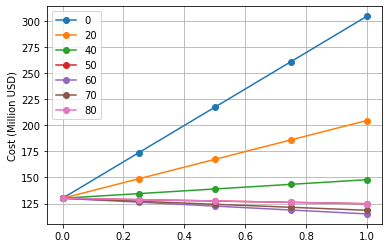

In [119]:
cost = pd.DataFrame(mAbs_cost).mean() + pd.DataFrame(hosp_cost).mean()
(cost.unstack() / 1_000_000).plot(marker='o')
plt.ylabel('Cost (Million USD)')
plt.grid();

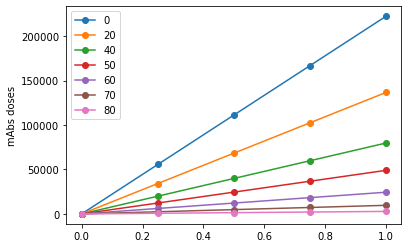

In [120]:
pd.DataFrame(doses).mean().unstack().plot(marker='o')
# plt.semilogy()
plt.ylabel('mAbs doses');

# Burden Averted

In [121]:
np.round(pd.Series({i: pd.DataFrame(n_COVID[i]).mean().sum() for i in n_COVID}).unstack(), 1)

,0,20,40,50,60,70,80
0.00,24206.4,24206.4,24206.4,24206.4,24206.4,24206.4,24206.4
0.25,19246.1,21157.5,22426.7,23112.0,23661.6,23990.7,24143.2
0.50,14285.7,18108.7,20647.0,22017.6,23116.8,23775.1,24080.0
0.75,9325.4,15059.8,18867.4,20923.2,22572.1,23559.5,24016.8
1.00,4365.1,12010.9,17087.7,19828.8,22027.3,23343.9,23953.7


In [154]:
symptomatic_infections_averted = (pd.DataFrame(n_COVID[0,0]).mean().sum()
                                  - pd.Series({i: pd.DataFrame(n_COVID[i]).mean().sum() for i in n_COVID})).unstack()
np.round(symptomatic_infections_averted,1)

,0,20,40,50,60,70,80
0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.25,4960.3,3048.9,1779.7,1094.4,544.8,215.6,63.2
0.50,9920.6,6097.7,3559.3,2188.8,1089.5,431.3,126.4
0.75,14880.9,9146.6,5339.0,3283.2,1634.3,646.9,189.5
1.00,19841.3,12195.4,7118.6,4377.6,2179.1,862.5,252.7


In [208]:
symptomatic_infections_averted.round(1)

,0,20,40,50,60,70,80
0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.25,4960.3,3048.9,1779.7,1094.4,544.8,215.6,63.2
0.50,9920.6,6097.7,3559.3,2188.8,1089.5,431.3,126.4
0.75,14880.9,9146.6,5339.0,3283.2,1634.3,646.9,189.5
1.00,19841.3,12195.4,7118.6,4377.6,2179.1,862.5,252.7


In [124]:
hospitalizations_averted = (pd.DataFrame(n_hosp[0,0]).mean().sum()
                            - pd.Series({i: pd.DataFrame(n_hosp[i]).mean().sum() for i in n_hosp})).unstack()
np.round(hospitalizations_averted,1)

,0,20,40,50,60,70,80
0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.25,503.6,463.6,391.5,317.3,216.2,111.8,41.1
0.50,1007.2,927.1,783.1,634.5,432.4,223.7,82.1
0.75,1510.8,1390.7,1174.6,951.8,648.6,335.5,123.2
1.00,2014.4,1854.3,1566.2,1269.0,864.8,447.3,164.3


In [125]:
deaths_averted = (pd.DataFrame(n_deaths[0,0]).mean().sum()
                  - pd.Series({i: pd.DataFrame(n_deaths[i]).mean().sum() for i in n_hosp})).unstack()
np.round(deaths_averted,1)

,0,20,40,50,60,70,80
0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.25,56.6,56.6,54.7,50.8,42.8,28.7,14.5
0.50,113.3,113.3,109.4,101.6,85.6,57.4,29.0
0.75,169.9,169.9,164.1,152.4,128.4,86.1,43.5
1.00,226.6,226.6,218.8,203.2,171.2,114.8,58.0


In [126]:
np.round(pd.DataFrame({'symptomatic_infections_averted':symptomatic_infections_averted.stack(),
              'hospitalizations_averted':hospitalizations_averted.stack(),
              'deaths_averted':deaths_averted.stack(),
#               'mAbs_cost':pd.Series(mAbs_cost)/1e6,
#               'hosp_cost':pd.Series(hosp_cost)/1e6,
#               'total_cost':cost/1e6,
              'thousand_doses':pd.DataFrame(doses).mean()/1e3,
              'incremental_cost':(cost-cost.loc[0,0])/1e6
             }).unstack(level=0), 1)

symptomatic_infections_averted                                    \
                             0.00    0.25    0.50     0.75     1.00   
0                             0.0  4960.3  9920.6  14880.9  19841.3   
20                            0.0  3048.9  6097.7   9146.6  12195.4   
40                            0.0  1779.7  3559.3   5339.0   7118.6   
50                            0.0  1094.4  2188.8   3283.2   4377.6   
60                            0.0   544.8  1089.5   1634.3   2179.1   
70                            0.0   215.6   431.3    646.9    862.5   
80                            0.0    63.2   126.4    189.5    252.7   

   hospitalizations_averted                                 ...  \
                       0.00   0.25    0.50    0.75    1.00  ...   
0                       0.0  503.6  1007.2  1510.8  2014.4  ...   
20                      0.0  463.6   927.1  1390.7  1854.3  ...   
40                      0.0  391.5   783.1  1174.6  1566.2  ...   
50                      0.0  317.3   634.5   951.8  1269.0  ...   
60                      0.0  216.2   432.4   648.6   864.8  ...   
70                      0.0  111.8   223.7   335.5   447.3  ...   
80                      0.0   41.1    82.1   123.2   164.3  ...   

   thousand_doses                            incremental_cost              \
             0.00  0.25   0.50   0.75   1.00             0.00  0.25  0.50   
0             0.0  55.6  111.2  166.8  222.4              0.0  43.6  87.1   
20            0.0  34.2   68.3  102.5  136.7              0.0  18.6  37.2   
40            0.0  19.9   39.9   59.8   79.8              0.0   4.4   8.9   
50            0.0  12.3   24.5   36.8   49.0              0.0  -1.3  -2.6   
60            0.0   6.1   12.2   18.3   24.4              0.0  -3.7  -7.5   
70            0.0   2.4    4.8    7.3    9.7              0.0  -2.9  -5.7   
80            0.0   0.7    1.4    2.1    2.8              0.0  -1.3  -2.6   

                  
     0.75   1.00  
0   130.7  174.3  
20   55.8   74.4  
40   13.3   17.8  
50   -4.0   -5.3  
60  -11.2  -15.0  
70   -8.6  -11.5  
80   -3.8   -5.1  

[7 rows x 25 columns]

In [127]:
ICER = (cost-cost.loc[0,0]) / (deaths_averted).stack()
np.round((ICER / 1_000).unstack(), 1)

,0,20,40,50,60,70,80
0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.25,769.1,328.5,81.3,-26.0,-87.5,-100.1,-88.5
0.50,769.1,328.5,81.3,-26.0,-87.5,-100.1,-88.5
0.75,769.1,328.5,81.3,-26.0,-87.5,-100.1,-88.5
1.00,769.1,328.5,81.3,-26.0,-87.5,-100.1,-88.5


Text(0.5, 0, 'Minimum age for PEP (years)')

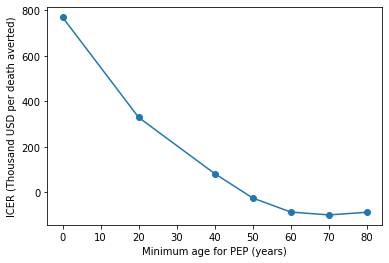

In [128]:
(ICER / 1_000).unstack().T.iloc[:,-1].plot(marker='o')
plt.ylabel('ICER (Thousand USD per death averted)')
plt.xlabel('Minimum age for PEP (years)')
# plt.semilogy();

# PEP with mAbs is a benefit for patients and for hospitals

In [129]:
def summary_results(coverage_level, age_lower_bound):
    n_symp_averted = symptomatic_infections_averted.loc[coverage_level, age_lower_bound]
    n_hosp_averted = hospitalizations_averted.loc[coverage_level, age_lower_bound]
    n_deaths_averted = deaths_averted.loc[coverage_level, age_lower_bound]
    unit_cost = mAbs_unit_cost
    incremental_cost = (cost.loc[coverage_level, age_lower_bound]-cost.loc[0,0])/1e6

    
    result_str = f"""Results: In a month of similar intensity to May, 2021,
    in USA, a program reaching {coverage_level*100:.0f}% of exposed household members
    aged {age_lower_bound}+, would avert {n_symp_averted:,.0f} symptomatic infections,
    {n_hosp_averted:,.0f} hospitalizations, and {n_deaths_averted:,.0f} deaths.  If the
    unit cost of administering the intervention was {pd.Series(unit_cost).mean():,.0f} dollars,
    this program would save the health system {-incremental_cost*1_000:,.0f} thousand dollars."""
    
    print(result_str)
summary_results(1/2, 50)

Results: In a month of similar intensity to May, 2021,
    in USA, a program reaching 50% of exposed household members
    aged 50+, would avert 2,189 symptomatic infections,
    635 hospitalizations, and 102 deaths.  If the
    unit cost of administering the intervention was 1,264 dollars,
    this program would save the health system 2,641 thousand dollars.


In [130]:
# summary_results(1/3, 50)

In [131]:
# summary_results(1/2, 50)

# Number-plugging values

In [132]:
print(f"""[[summary of data: RCT included X subjects (Y in treatment group and Z in control),
which we combined with confirmed cases data on {len(df_cdc_month):,.0f} individuals and
household structure data derived from {len(acs):,.0f} individuals in {acs.household_id.nunique():,.0f} households.]]
""")

[[summary of data: RCT included X subjects (Y in treatment group and Z in control),
which we combined with confirmed cases data on 154,136 individuals and
household structure data derived from 3,239,553 individuals in 1,428,037 households.]]



In [133]:
n_2 = pd.DataFrame(n_2_unvax)
n_2

0             1             2   \
[0, 10)   male   White     11289.959616  10237.660989  11105.096347   
                 Black      4301.710333   3810.425563   3725.854891   
                 Hispanic   5050.165986   4691.354787   4404.492619   
                 Other      3202.091348   2631.721755   2674.295693   
          female White     11490.769619   9037.961656   9387.945507   
...                                 ...           ...           ...   
[80, 125) male   Other       172.306661    133.254279    156.061568   
          female White       716.065491    685.038004   1105.682583   
                 Black       370.228541    288.998769    423.104223   
                 Hispanic    144.990958    253.204983    263.343285   
                 Other       202.267560    233.607994    183.199214   

                                     3            4             5   \
[0, 10)   male   White     10875.519637  9743.198806  10971.414092   
                 Black      3683.287704  3379.253283   3968.557468   
                 Hispanic   4257.321206  3975.411292   4281.242246   
                 Other      2090.550222  2403.397378   2382.291442   
          female White     10224.146416  9596.936823  10908.268123   
...                                 ...          ...           ...   
[80, 125) male   Other       120.872109   153.908964    121.373617   
          female White       915.068756  1053.145926    852.264278   
                 Black       183.179949   345.779433    306.957739   
                 Hispanic    283.820317   191.829044    150.759764   
                 Other       206.217313   217.793984    177.076086   

                                     6             7             8   \
[0, 10)   male   White     11056.707580   9600.492687  10280.841049   
                 Black      3253.639728   3762.243329   3484.429437   
                 Hispanic   4144.495268   5035.546149   4028.773489   
                 Other      2536.685131   2668.966963   2225.385738   
          female White      8931.119520  10504.603977  10364.746552   
...                                 ...           ...           ...   
[80, 125) male   Other       106.672708    115.942424    153.490496   
          female White       865.229661    835.803380    990.420918   
                 Black       373.696481    266.742783    286.270193   
                 Hispanic    205.919041    210.371922    248.191967   
                 Other       133.096596    204.084202    143.435671   

                                     9   ...           90            91  \
[0, 10)   male   White     10409.931216  ...  8702.175283  10923.321432   
                 Black      3594.662580  ...  3942.938853   3720.180764   
                 Hispanic   4033.129411  ...  4257.390169   4183.582168   
                 Other      2265.528810  ...  2391.010285   2465.540593   
          female White      9712.882863  ...  9326.241106   9155.946997   
...                                 ...  ...          ...           ...   
[80, 125) male   Other       139.765994  ...    95.000980     99.395256   
          female White       781.328609  ...   845.989051    928.667178   
                 Black       271.588957  ...   307.074553    379.026488   
                 Hispanic    200.687305  ...   198.954669    225.823882   
                 Other       168.403794  ...   179.984651    183.932292   

                                     92            93            94  \
[0, 10)   male   White     10799.029255  10433.169786   9960.414248   
                 Black      3582.510501   3817.432903   4122.738382   
                 Hispanic   3940.010208   4679.737695   4556.204743   
                 Other      2088.483543   2246.791881   2709.772453   
          female White      9733.515455   9906.342887  10159.658279   
...                                 ...           ...           ...   
[80, 125) male   Other        94.713938    171.420223    118.000368   
          female Whit

In [134]:
print(f"""[[Confirmed case and household structure results,
summarizing something about the racial segregation of household structure,
the age-assortativity. In [[May]], there were [[{len(df_cdc_month):,.0f}]]
confirmed cases of COVID-19, which we estimate resulted
in {n_2.sum().mean():,.0f} (95% UI {np.percentile(n_2.sum(), 2.5):,.0f}-{np.percentile(n_2.sum(), 97.5):,.0f}) individuals with household exposure to COVID-19. ]] [[stratify counts or rates by race??]]""")

[[Confirmed case and household structure results,
summarizing something about the racial segregation of household structure,
the age-assortativity. In [[May]], there were [[154,136]]
confirmed cases of COVID-19, which we estimate resulted
in 222,367 (95% UI 207,597-236,665) individuals with household exposure to COVID-19. ]] [[stratify counts or rates by race??]]


In [135]:
n_2.unstack().sum().unstack().mean()

Black        37410.477830
Hispanic     43625.197635
Other        23758.111937
White       117573.492902
dtype: float64

In [136]:
print(f"""[[Number who receive PEP in alternative scenarios, and for alternative age cutoffs. Perhaps in a table?  Population-level rates of treatment stratified by race?]]""")

[[Number who receive PEP in alternative scenarios, and for alternative age cutoffs. Perhaps in a table?  Population-level rates of treatment stratified by race?]]


In [137]:
def my_summary(x):
    mean = np.mean(x)
    lb = np.percentile(x, 2.5)
    ub = np.percentile(x, 97.5)
    results = locals()
    results.pop('x')
    for k in results:
        results[k] = '{:,.0f}'.format(results[k])
    results['ui'] = results['lb']+'-'+results['ub']
    results['mean_and_ui'] = f"""{results['mean']} (95% UI {results['ui']})"""
    return results

total_PEP = {}
for c,a in n_PEP.keys():
    total_PEP[c,a] = my_summary(pd.DataFrame(n_PEP[c,a]).sum())

In [138]:
print(f"""In a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
we estimate {total_PEP[.5,50]['mean_and_ui']} individuals would be treated.""")

In a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
we estimate 24,509 (95% UI 22,666-26,372) individuals would be treated.


In [139]:
print(f"""While in a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate {total_PEP[.5,80]['mean']} (95% UI {total_PEP[.5,80]['ui']}) individuals would be treated,""")

While in a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate 1,415 (95% UI 1,208-1,659) individuals would be treated,


In [140]:
print(f"""and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
we estimate {total_PEP[.5,20]['mean']} (95% UI {total_PEP[.5,20]['ui']}) individuals would be treated.""")

and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
we estimate 68,333 (95% UI 63,483-72,465) individuals would be treated.


In [141]:
total_COVID = {}
for c,a in n_COVID.keys():
    total_COVID[c,a] = my_summary(pd.DataFrame(n_COVID[c,a]).sum())

In [142]:
print(f"""[[Number who develop symptomatic COVID-19 in baseline and alternative scenarios, and for alternative age cutoffs. Including stratification by race and ethnicity.]]""")

print(f"""We estimate that without PEP, {total_COVID[0,0]['mean_and_ui']} individuals developed a symptomatic COVID-19 infection from a household exposure,
      while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
{total_COVID[.5,50]['mean_and_ui']} individuals developed a symptomatic infection.""")

[[Number who develop symptomatic COVID-19 in baseline and alternative scenarios, and for alternative age cutoffs. Including stratification by race and ethnicity.]]
We estimate that without PEP, 17,429 (95% UI 13,699-21,491) individuals developed a symptomatic COVID-19 infection from a household exposure,
      while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
15,853 (95% UI 12,491-19,435) individuals developed a symptomatic infection.


In [143]:
print(f"""In a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate {total_COVID[.5,80]['mean_and_ui']} individuals developed symptomatic infection,
and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
we estimate {total_COVID[.5,20]['mean_and_ui']} individuals developed symptomatic infection.""")

In a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate 17,338 (95% UI 13,632-21,374) individuals developed symptomatic infection,
and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
we estimate 13,038 (95% UI 10,252-16,100) individuals developed symptomatic infection.


In [144]:
total_hosp = {}
for c,a in n_hosp.keys():
    total_hosp[c,a] = my_summary(pd.DataFrame(n_hosp[c,a]).sum())
total_deaths = {}
for c,a in n_deaths.keys():
    total_deaths[c,a] = my_summary(pd.DataFrame(n_deaths[c,a]).sum())

In [145]:
print(f"""We estimate that without PEP, {total_hosp[0,0]['mean_and_ui']} individuals would be hospitalized
because of a COVID-19 infection from a household exposure,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
{total_hosp[.5,50]['mean_and_ui']} individuals would be hospitalized;
in a scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate {total_hosp[.5,80]['mean_and_ui']} individuals would be hospitalized,
and in a scenario where 50% of those exposed and of age 20 or older receive PEP,
{total_hosp[.5,20]['mean_and_ui']} individuals would be hospitalized.
""")

We estimate that without PEP, 1,769 (95% UI 1,387-2,190) individuals would be hospitalized
because of a COVID-19 infection from a household exposure,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
1,312 (95% UI 1,034-1,631) individuals would be hospitalized;
in a scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate 1,710 (95% UI 1,345-2,108) individuals would be hospitalized,
and in a scenario where 50% of those exposed and of age 20 or older receive PEP,
1,101 (95% UI 852-1,369) individuals would be hospitalized.



In [146]:
print(f"""We estimate that without PEP, {total_deaths[0,0]['mean_and_ui']} individuals would die
because of a COVID-19 infection from a household exposure,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
{total_deaths[.5,50]['mean_and_ui']} individuals would die;
in a scenario where 50% of those exposed and of age 80 or older receive PEP,
{total_deaths[.5,80]['mean_and_ui']} individuals would die,
and in a scenario where 50% of those exposed and of age 20 or older receive PEP,
{total_deaths[.5,20]['mean_and_ui']} individuals would die.
""")

We estimate that without PEP, 199 (95% UI 155-250) individuals would die
because of a COVID-19 infection from a household exposure,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
125 (95% UI 98-156) individuals would die;
in a scenario where 50% of those exposed and of age 80 or older receive PEP,
178 (95% UI 139-221) individuals would die,
and in a scenario where 50% of those exposed and of age 20 or older receive PEP,
117 (95% UI 91-146) individuals would die.



In [147]:
total_cost = {}
hosp_cost_str = {}
PEP_cost = {}
savings = {}
incremental_cost = {}

total_cost_0 = (pd.Series(mAbs_cost[0,0]) + pd.Series(hosp_cost[0,0])) / 1_000_000

for c,a in n_hosp.keys():
    total_cost_ca = (pd.Series(mAbs_cost[c,a]) + pd.Series(hosp_cost[c,a])) / 1_000_000
    total_cost[c,a] = my_summary(total_cost_ca)
    savings[c,a] = my_summary(total_cost_0 - total_cost_ca)
    incremental_cost[c,a] = my_summary(total_cost_ca - total_cost_0)
    hosp_cost_str[c,a] = my_summary(pd.Series(hosp_cost[c,a])/1_000_000)
    PEP_cost[c,a] = my_summary(pd.Series(mAbs_cost[c,a])/1_000_000)
    

In [148]:
print(f"""We estimate that without PEP, the cost of hospitalizations due to COVID-19 infections from
household exposure would be {hosp_cost_str[0,0]['mean_and_ui']} million dollars,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
the cost of hospitalizations would be {hosp_cost_str[.5,50]['mean_and_ui']} million dollars and
the cost of PEP would be {PEP_cost[.5,50]['mean_and_ui']} million dollars,
for a total of {total_cost[.5,50]['mean_and_ui']} million dollars,
which is a savings of {savings[.5,50]['mean_and_ui']} million dollars compared to the without-PEP scenario.
In a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
the cost of hospitalizations would be {hosp_cost_str[.5,80]['mean_and_ui']} million dollars and
the cost of PEP would be {PEP_cost[.5,80]['mean_and_ui']} million dollars,
for a total of {total_cost[.5,80]['mean_and_ui']} million dollars,
which is a savings of {savings[.5,80]['mean_and_ui']} million dollars compared to the without-PEP scenario;
and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
the cost of hospitalizations would be {hosp_cost_str[.5,20]['mean_and_ui']} million dollars and
the cost of PEP would be {PEP_cost[.5,20]['mean_and_ui']} million dollars,
for a total of {total_cost[.5,20]['mean_and_ui']} million dollars,
which is a total of {incremental_cost[.5,20]['mean_and_ui']} million dollars more than in the without-PEP scenario.
""")

We estimate that without PEP, the cost of hospitalizations due to COVID-19 infections from
household exposure would be 130 (95% UI 94-181) million dollars,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
the cost of hospitalizations would be 96 (95% UI 71-133) million dollars and
the cost of PEP would be 31 (95% UI 25-39) million dollars,
for a total of 127 (95% UI 99-163) million dollars,
which is a savings of 3 (95% UI -12-16) million dollars compared to the without-PEP scenario.
In a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
the cost of hospitalizations would be 126 (95% UI 91-175) million dollars and
the cost of PEP would be 2 (95% UI 1-2) million dollars,
for a total of 127 (95% UI 92-177) million dollars,
which is a savings of 3 (95% UI 1-4) million dollars compared to the without-PEP scenario;
and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
the

In [149]:
total_cost[c,a]

{'mean': '125',
 'lb': '91',
 'ub': '172',
 'ui': '91-172',
 'mean_and_ui': '125 (95% UI 91-172)'}

In [150]:
import seaborn as sns

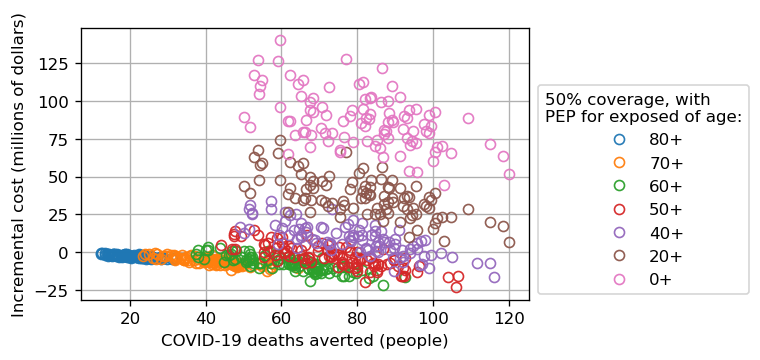

In [151]:
plt.figure(figsize=(6.5,3), dpi=120)
for c in [0.25, .5, .75]:
    for i, a in enumerate(age_lower_bounds[::-1]):
        s_cost = (pd.Series(mAbs_cost[c,a]) + pd.Series(hosp_cost[c,a])) / 1e6
        s_cost -= (pd.Series(mAbs_cost[0,0]) + pd.Series(hosp_cost[0,0])) / 1e6
        
        s_deaths = pd.DataFrame(n_deaths[c,a]).sum(axis=0)
        s_deaths -= pd.DataFrame(n_deaths[0,0]).sum(axis=0)
        s_deaths *= -1
        
        if c == 0.5:
            plt.plot(s_deaths, s_cost, 'o', label=f'{a}+', alpha=.95, color='none', mec=f'C{i}', mew=1)
#         else:
#             plt.plot(s_deaths, s_cost, 'o', color='grey')
plt.legend(loc=(1.02, .02), title='50% coverage, with\nPEP for exposed of age:')
plt.xlabel('COVID-19 deaths averted (people)')
plt.ylabel('Incremental cost (millions of dollars)')
plt.grid()
plt.subplots_adjust(right=.7);

In [152]:
attack_rate_without_mAbs.shape

(100,)